In [536]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer


def load_dataset():
    return pd.read_csv('./winequalityN.csv', sep=',')


df = load_dataset()


In [537]:
def prepare_text_columns(df: pd.DataFrame):
    df.type = df.type.map({'white': 1, 'red': 0}).astype('int64')


prepare_text_columns(df)

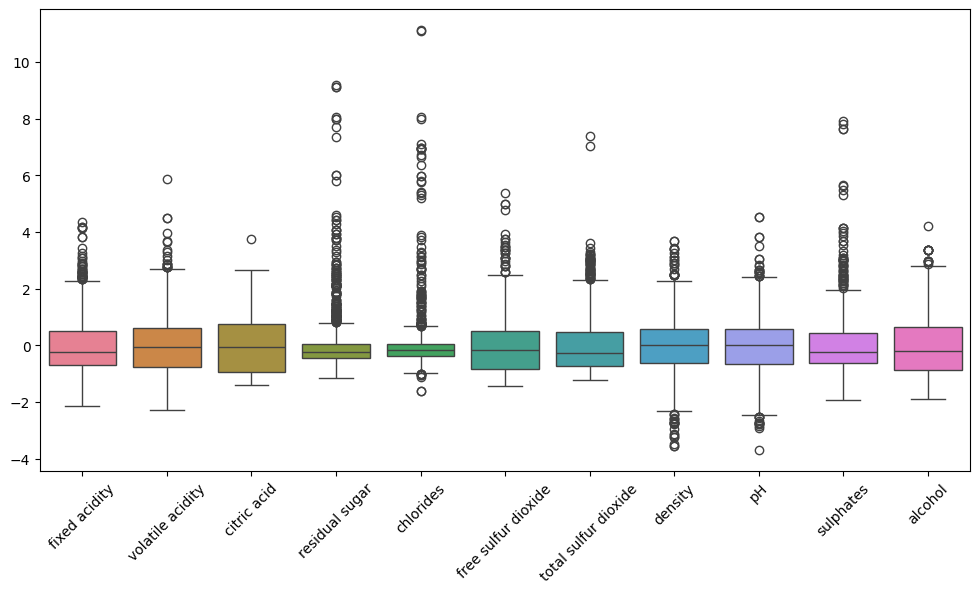

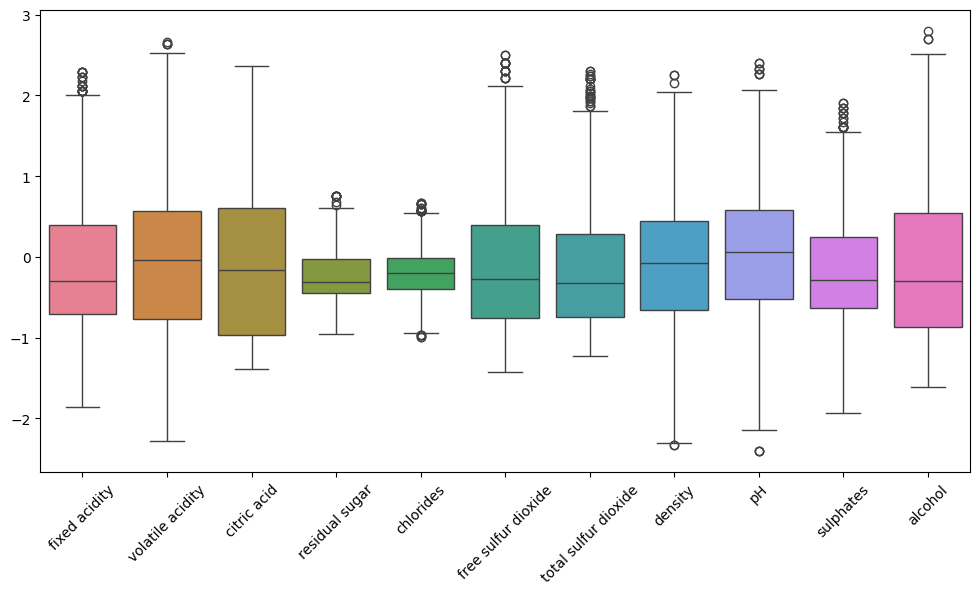

(1194, 11)


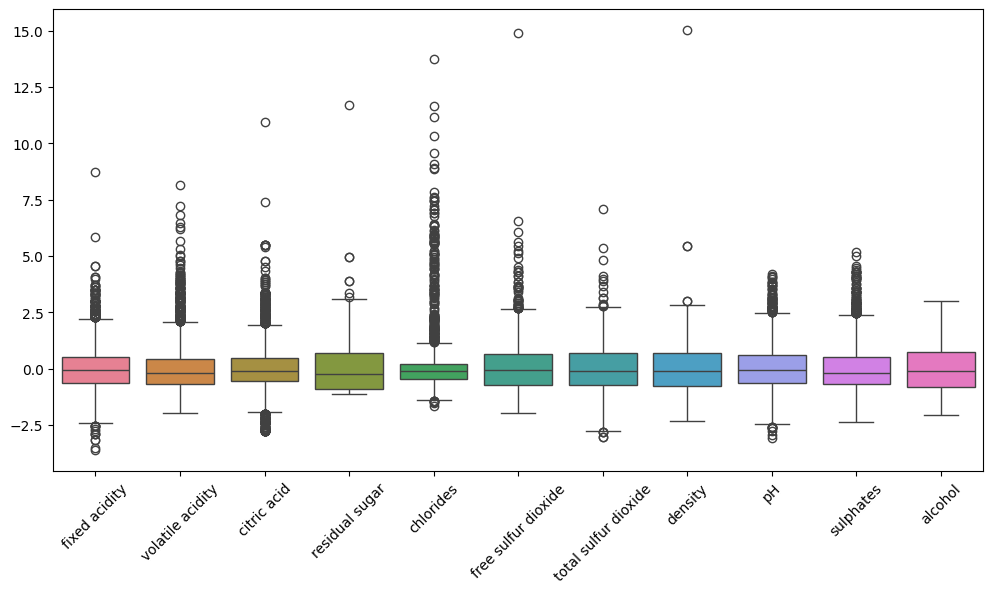

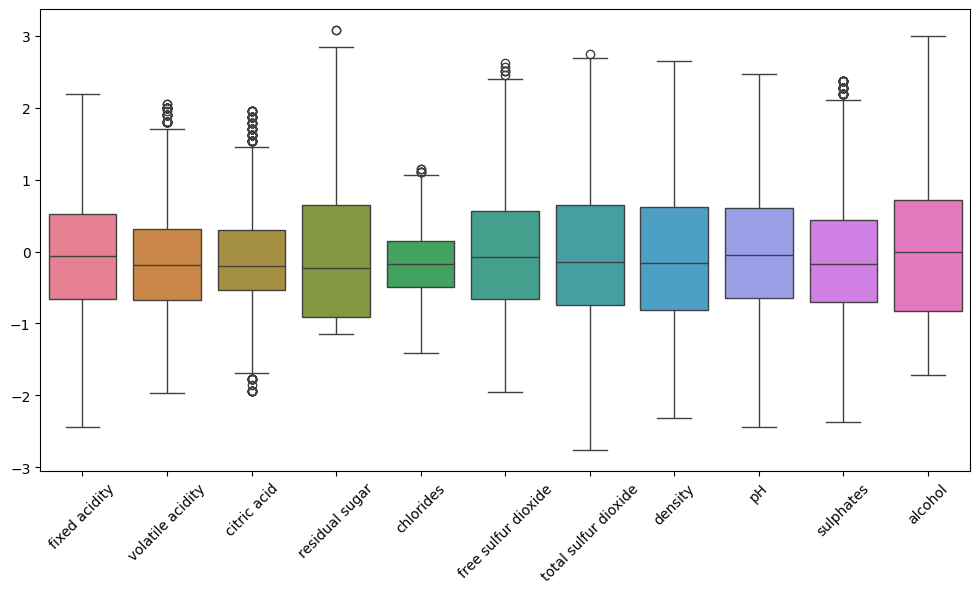

(4002, 11)


In [538]:
def box_plot(wine_processed):
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=wine_processed)
    plt.xticks(rotation=45)
    plt.show()


def preprocess_data(df: pd.DataFrame):
    """Предобработка данных: заполнение пропусков, центрирование и нормирование"""
    # Разделяем данные
    wine_numerical = df.drop(['type', 'quality'], axis=1)  # Числовые признаки
    wine_quality = df['quality']  # Оценка экспертов

    # Заполнение пропусков средними значениями
    imputer = SimpleImputer(strategy='mean')
    wine_numerical_imputed = pd.DataFrame(imputer.fit_transform(wine_numerical), columns=wine_numerical.columns)

    # Центрирование и нормирование
    scaler = StandardScaler()
    wine_processed = pd.DataFrame(scaler.fit_transform(wine_numerical_imputed), columns=wine_numerical_imputed.columns)

    box_plot(wine_processed)

    # Убираем выбросы
    Q1 = wine_processed.quantile(0.25)
    Q3 = wine_processed.quantile(0.75)
    IQR = Q3 - Q1

    mask = ~((wine_processed < (Q1 - 1.5 * IQR)) | (wine_processed > (Q3 + 1.5 * IQR))).any(axis=1)

    wine_processed = wine_processed[mask]
    wine_quality = wine_quality[mask]

    box_plot(wine_processed)
    print(wine_processed.shape)

    return wine_processed, wine_quality

wines = {
    'RED': preprocess_data(df.loc[df.type == 0].reset_index(drop=True)),
    'WHITE': preprocess_data(df.loc[df.type == 1].reset_index(drop=True)),
}


In [539]:
def get_dataset_statistics(df: pd.DataFrame):
    """Вывод основных статистик набора данных"""
    print('Statistic')
    print('---mean---')
    print(df.mean())
    print('---std---')
    print(df.std())
    print('---min---')
    print(df.min())
    print('---max---')
    print(df.max())
    print('---median---')
    print(df.median())
    print('---missing values---')
    print(df.isnull().sum())


get_dataset_statistics(df)

Statistic
---mean---
type                      0.753886
fixed acidity             7.216579
volatile acidity          0.339691
citric acid               0.318722
residual sugar            5.444326
chlorides                 0.056042
free sulfur dioxide      30.525319
total sulfur dioxide    115.744574
density                   0.994697
pH                        3.218395
sulphates                 0.531215
alcohol                  10.491801
quality                   5.818378
dtype: float64
---std---
type                     0.430779
fixed acidity            1.296750
volatile acidity         0.164649
citric acid              0.145265
residual sugar           4.758125
chlorides                0.035036
free sulfur dioxide     17.749400
total sulfur dioxide    56.521855
density                  0.002999
pH                       0.160748
sulphates                0.148814
alcohol                  1.192712
quality                  0.873255
dtype: float64
---min---
type                    0.00000


In [540]:
def perform_pca(data, n_components=2):
    pca = PCA(n_components=n_components)
    pca.fit(data)
    return pca


def optimal_components_plot(pca):
    """График для определения оптимального числа компонент"""
    plt.figure(figsize=(10, 6))
    variance_by_components = np.cumsum(pca.explained_variance_ratio_)
    number_of_components = np.arange(1, variance_by_components.size + 1, 1)
    plt.plot(number_of_components, variance_by_components, marker='o')
    plt.xticks(number_of_components)
    plt.xlabel('Number of components')
    plt.ylabel('Cumulative explained variance')
    plt.title('Доля объясненной дисперсии по компонентам')
    plt.grid()
    plt.show()



In [541]:
def plot_scores(pca, scores, labels):
    """Визуализация счетов (проекций данных на главные компоненты)"""

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        scores[:, 0],
        scores[:, 1],
        c=labels,
        alpha=1,
        cmap='coolwarm',
        s=10
    )
    plt.xlabel('PC1 (Доля дисперсии: {:.1f}%)'.format(pca.explained_variance_ratio_[0] * 100))
    plt.ylabel('PC2 (Доля дисперсии: {:.1f}%)'.format(pca.explained_variance_ratio_[1] * 100))
    plt.title('График счетов PCA')
    plt.grid()
    plt.colorbar(scatter, label='Качество вина')
    plt.show()


def plot_loadings(pca, feature_names):
    """Визуализация нагрузок (влияния исходных признаков на главные компоненты)."""
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

    plt.figure(figsize=(10, 8))
    plt.scatter(loadings[:, 0], loadings[:, 1], alpha=0)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('График нагрузок PCA')
    plt.grid()

    for i, feature in enumerate(feature_names):
        plt.annotate(feature, (loadings[i, 0], loadings[i, 1]), fontsize=10)

    circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
    plt.gca().add_artist(circle)
    plt.axhline(0, color='gray', linestyle='--')
    plt.axvline(0, color='gray', linestyle='--')
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.show()


------------------------------RED WINE------------------------------


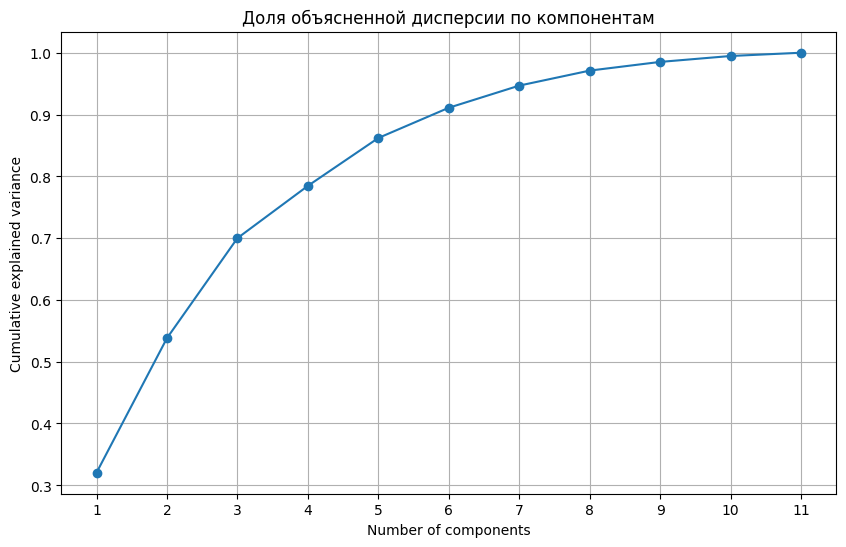

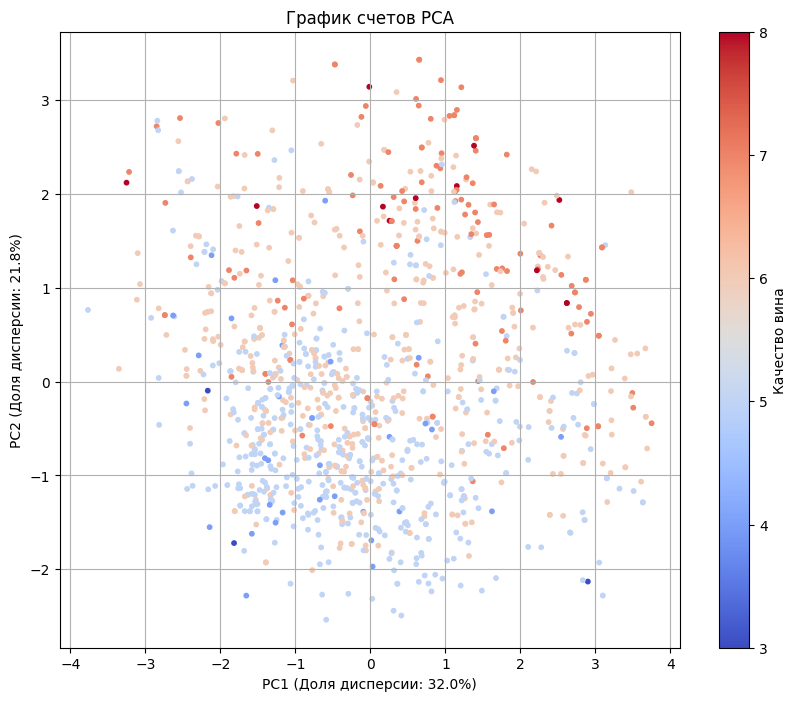

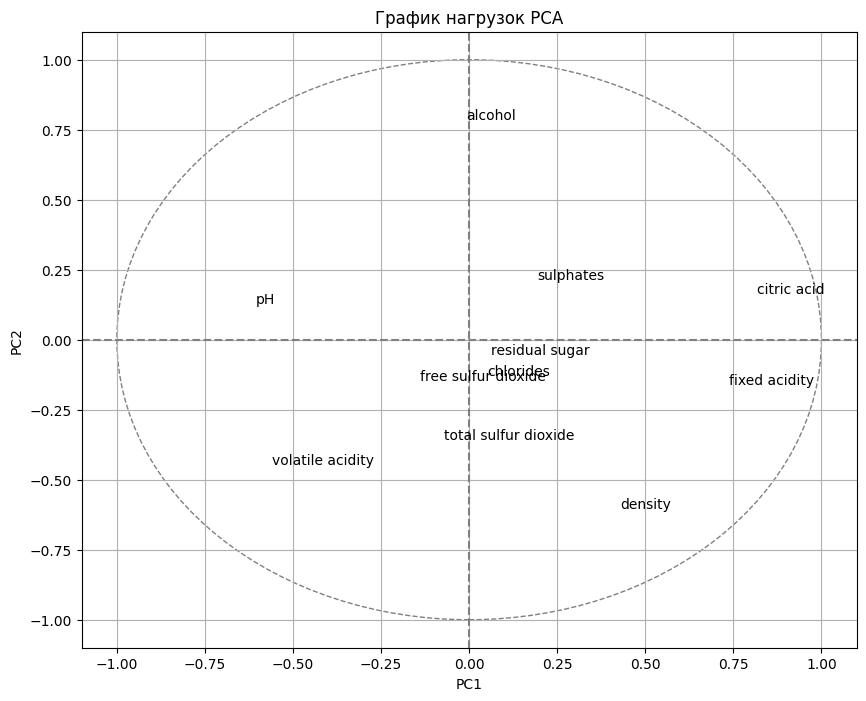

------------------------------WHITE WINE------------------------------


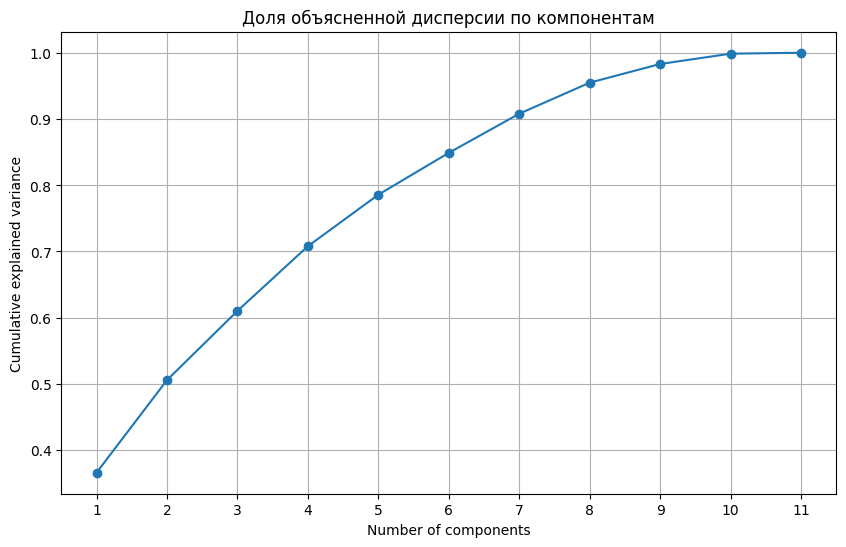

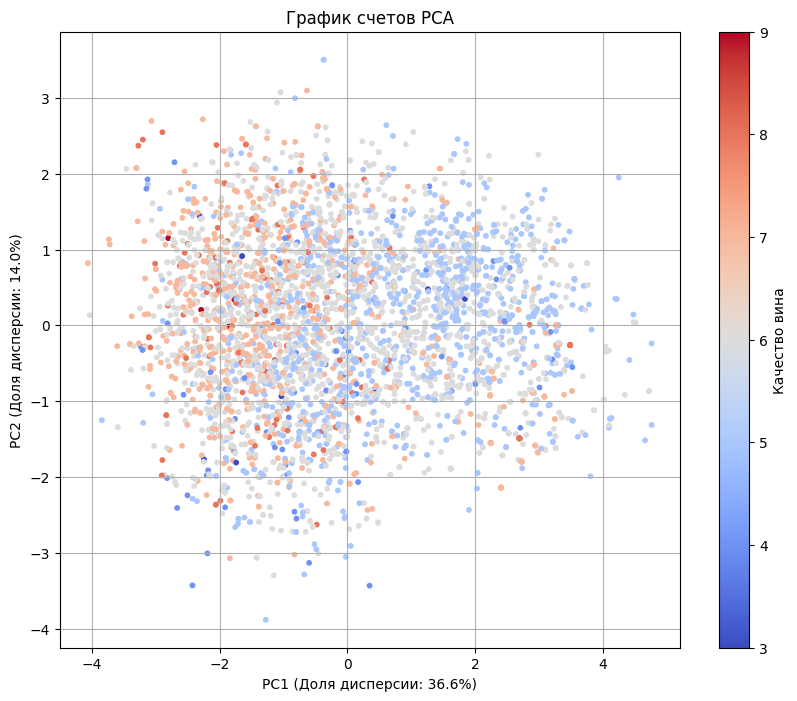

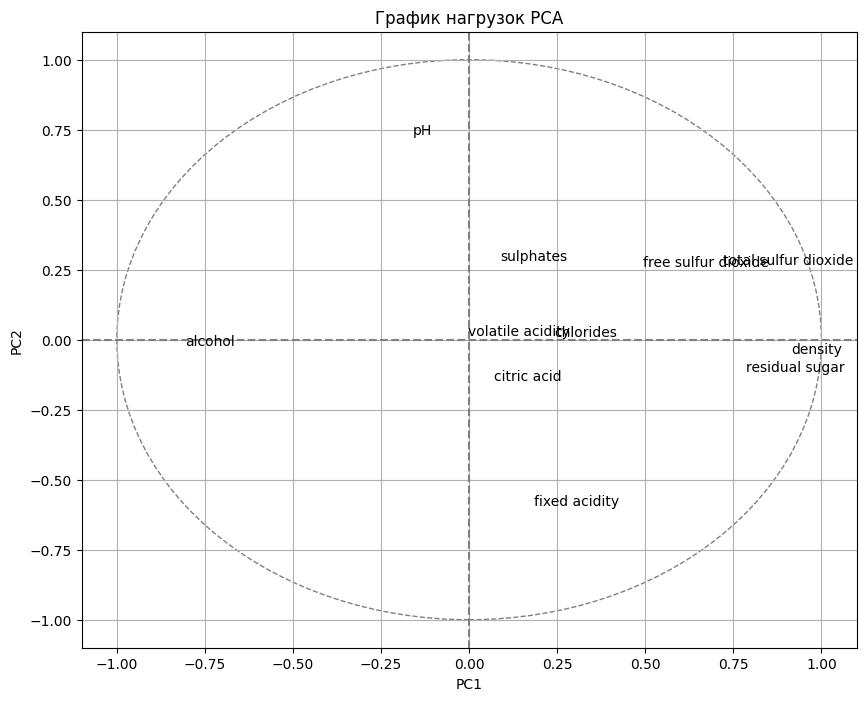

In [542]:
for wine_type, (wine_processed, wine_quality) in wines.items():
    print(f"{'-' * 30}{wine_type} WINE{'-' * 30}")
    pca = perform_pca(wine_processed, 11)
    optimal_components_plot(pca)
    pca = perform_pca(wine_processed, 2)

    plot_scores(pca, pca.transform(wine_processed), labels=wine_quality)
    plot_loadings(pca, feature_names=wine_processed.columns)
